<a href="https://colab.research.google.com/github/tawfiqam/MI564/blob/main/LDA_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install psaw

In [2]:
def compute_coherence_values(dictionary, corpus, texts, limit=100, start=10, step=10):
    """
    You will need to change the chunksize in reference to the size of the corpus. A more detailed explanation can be found here:
    https://miningthedetails.com/blog/python/lda/GensimLDA/
    
    For the Parenting and MensRightrs corpora, I think the chunksize would be around 50,000
    
    Compute c_v coherence for various number of topics
    
    Parameters to change:
    -----------
    chunksize
    workers:
    on big laptop, the total number of cores = 8, so set to 6 (usually n-2)
    on small laptop, the local numeber of cores = 5, so set to 3
    on server, set to 9-10 workers

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    chunksize = 1000
    passes = 20
    workers = 6
    
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics, 
                                   random_state=100,
                                   chunksize=chunksize,
                                   passes=passes,
                                   per_word_topics=True,
                                   workers=workers)
        print('saving the LDA model...')
        Filename = "LDA_Model_"+str(num_topics)+".model"
        model.save(Filename)
        model_list.append(model)
        print('done with model ',str(num_topics))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        print('coherence metric is ',str(coherencemodel.get_coherence()))
        coherence_values.append(coherencemodel.get_coherence())
        #perplexity_values.append(lda_model.log_perplexity(corpus))
    return model_list, coherence_values


In [3]:
def first_pass(text): 
    text = str(text)
    text = text.replace('\\n',' ')
    text = text.replace('&amp',' ')
    text = text.replace(';#x200B;',' ')
    text = text.replace('nbsp',' ')
    
    return text

In [4]:
def clean_text(text): 
    #make string lowercase 
    text = str(text)
    text = text.lower()
    
    #remove links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

    #tokenize
    tokens = nltk.word_tokenize(text) 
    clean_text = []
    
    #remove stopwords, puncuation, then lemmatize
    for word in tokens:
        if (word not in stopwords_english and word not in string.punctuation): 
            token = wordnet_lemmatizer.lemmatize(word)
            clean_text.append(token)
            
    #remove words of length 3 or smaller        
    clean_text = [token for token in clean_text if len(token) > 3] 
            
    return clean_text      

In [5]:
import pandas as pd
#we will need datetime in order to specify the timeline we need to collect the data
import datetime as dt
#regular expressions will help us clean the text
import re
#gensim
import gensim
#LDA model
from gensim.models import LdaModel
#Use this to setup a dictionay
from gensim.corpora import Dictionary
#This will allow us to get the coherence models
from gensim.models import CoherenceModel
#gensim is a python library used mostly for NLP analysis
#corpora allows us to build a corpus out of different 
#documents
from gensim import corpora
#Defaultdict is a container like dictionaries present in the module collections. 
#Defaultdict is a sub-class of the dict class that returns a dictionary-like object. 
#The functionality of both dictionaries and defualtdict are almost same except for 
#the fact that defualtdict never raises a KeyError. It provides a default value 
#for the key that does not exists.
from collections import defaultdict

#importing ntlk
import nltk
from nltk.corpus import stopwords 
#use nltk to get stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#create a stoplist that includes all the english stop words
stopwords_english = stopwords.words('english')
display('here is a subset of the stop words')
display(stopwords_english[0:10])
#now we import the wrapper in order to use the API
# Text Cleaning
import string


#Generating n-grams
from gensim.models import Phrases

from psaw import PushshiftAPI

api = PushshiftAPI()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'here is a subset of the stop words'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [6]:
#doc is of type - list. Expecting the tokenized sentences 
def add_ngram(doc): 
    return trigram[bigram[doc]]

In [7]:
#this function will allow us to find the last day of each month
#for example, there are 31 days in January, but 28 this February
def last_day_of_month(any_day):
    # this will never fail
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - datetime.timedelta(days=next_month.day)

In [8]:
import datetime
subredditlist = ['Ex_Foster']
for reddit in subredditlist:
    for y in range(2019,2021):
      for i in range(1,12):
          file_name= str(reddit)+"_"+str(y)+"_"+str(i)+".json"
          print("starting with the month "+str(i))
          print("for subreddit..."+str(reddit))
          print("setting start epoch...")
          start_epoch=int(dt.datetime(y, i, 1).timestamp())
          print("setting end epoch...")
          last_day = last_day_of_month(datetime.date(y, i, 1))
          print("the last day of the month is...")
          print(last_day.day)
          last_day = int(last_day.day)
          end_epoch = int(dt.datetime(y,i,last_day).timestamp())
          print("setting up the generator...")
          gen = api.search_comments(after=start_epoch, before=end_epoch,subreddit=reddit)
          print("setting up the dataframe...")
          df = pd.DataFrame([obj.d_ for obj in gen])
          print("The number of comments for year "+ str(y)+" and month "+str(i)+" is "+str(len(df.index)))
          df.to_json(file_name)

starting with the month 1
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 1 is 0
starting with the month 2
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
28
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 2 is 0
starting with the month 3
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 3 is 69
starting with the month 4
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
30
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 4 is 233
starting with the month 5
for sub

/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


The number of comments for year 2019 and month 5 is 119
starting with the month 6
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
30
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 6 is 183
starting with the month 7
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 7 is 78
starting with the month 8
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
31
setting up the generator...
setting up the dataframe...
The number of comments for year 2019 and month 8 is 80
starting with the month 9
for subreddit...Ex_Foster
setting start epoch...
setting end epoch...
the last day of the month is...
30
setting up the generator...
setting up the dataframe...
The number of comments for yea

In [9]:
df['clean_text'] = df.body.apply(first_pass)

In [10]:
df['clean_text'] = df.clean_text.apply(clean_text)

In [11]:
docs = df['clean_text']

In [12]:
docs

0     [posting, specifically, said, coping, well, we...
1     [really, sorry, loss, losing, tough, form, bon...
2     [thank, courage, tell, truly, sorry, hope, alw...
3     [sorry, loss, really, tell, photo, lucky, love...
4     [sorry, loss, glad, love, year, hurt, loved, m...
                            ...                        
95    [never, option, head, supposed, live, fundamen...
96    [thank, much, gotten, writing, always, loved, ...
97    [going, write, detailed, reply, horrible, goin...
98    [understand, relate, would, trying, ingrain, n...
99    [agree, feel, foster, care, never, fault, unde...
Name: clean_text, Length: 100, dtype: object

In [13]:
# Get token frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in docs:
    for token in text:
        frequency[token]+=1


In [14]:
wordfreq = {}
for text in docs:
    for token in text:
        wordfreq[token]=frequency[token]

In [15]:
from itertools import islice

import operator

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

higherfreq2 = {k:v for k, v in wordfreq.items() if v>10}  
sorted_x = sorted(higherfreq2.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_x)

[('like', 42), ('family', 40), ('people', 29), ('know', 26), ('going', 25), ('year', 23), ('even', 22), ('want', 22), ('care', 21), ('sorry', 21), ('life', 21), ('feel', 21), ('thing', 21), ('foster', 21), ('time', 20), ('good', 19), ('really', 17), ('home', 17), ('help', 16), ('love', 15), ('parent', 15), ('could', 14), ('always', 13), ('would', 13), ('better', 13), ('need', 12), ('someone', 12), ('also', 12), ('though', 12), ('holiday', 12), ('well', 11), ('come', 11), ('take', 11), ('make', 11), ('much', 11), ('work', 11), ('friend', 11)]


In [16]:
dictionary = corpora.Dictionary(docs)
print(len(dictionary))
dictionary.save('Ex_Foster.dict')
print(dictionary)

1051
Dictionary(1051 unique tokens: ['anti', 'anxiety', 'cancer', 'care', 'cleaning']...)


In [17]:
corpus = [dictionary.doc2bow(text) for text in docs]
corpora.MmCorpus.serialize('Ex_Foster.mm', corpus)
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1)]]


In [18]:
id2word = corpora.Dictionary(docs)

In [19]:
print(id2word[0])

anti


In [20]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])


[[('anti', 1), ('anxiety', 1), ('cancer', 1), ('care', 1), ('cleaning', 1), ('come', 1), ('coping', 1), ('could', 1), ('dead', 1), ('dealing', 1), ('describing', 1), ('died', 1), ('doctor', 1), ('easy', 1), ('enough', 1), ('felt', 1), ('find', 1), ('found', 1), ('full', 1), ('game', 1), ('going', 1), ('important', 1), ('lose', 2), ('lost', 1), ('medicine', 1), ('monday', 1), ('month', 1), ('overwhelmed', 1), ('physician', 1), ('posting', 1), ('prescribe', 1), ('primary', 1), ('real', 1), ('said', 1), ('socializing', 1), ('sometimes', 1), ('specifically', 1), ('spiraled', 1), ('stopped', 2), ('sudden', 1), ('term', 1), ('thursday', 1), ('time', 1), ('took', 1), ('un-lose', 1), ('video', 1), ('well', 2), ('without', 1), ('world', 1)]]


In [23]:
# Can take a long time to run.

limit = 210
start = 10
step  = 10



model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=start, limit=limit, step=step)


saving the LDA model...
done with model  10
coherence metric is  0.3339214851692642
saving the LDA model...
done with model  20
coherence metric is  0.3779247884197847
saving the LDA model...
done with model  30
coherence metric is  0.383778137812637
saving the LDA model...
done with model  40
coherence metric is  0.42161858752511866
saving the LDA model...
done with model  50
coherence metric is  0.4268513967123873
saving the LDA model...
done with model  60
coherence metric is  0.44229740608497214
saving the LDA model...
done with model  70
coherence metric is  0.47169881149198717
saving the LDA model...
done with model  80
coherence metric is  0.44894194659133396
saving the LDA model...
done with model  90
coherence metric is  0.49466693333679534


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


saving the LDA model...
done with model  100
coherence metric is  0.4806486131263663
saving the LDA model...
done with model  110
coherence metric is  0.4657444431231199
saving the LDA model...
done with model  120
coherence metric is  0.4637898663215886
saving the LDA model...
done with model  130
coherence metric is  0.4698510738749141
saving the LDA model...
done with model  140
coherence metric is  0.461942983830826
saving the LDA model...
done with model  150
coherence metric is  0.4457215921990442
saving the LDA model...
done with model  160
coherence metric is  0.45174267720605055
saving the LDA model...
done with model  170
coherence metric is  0.4564084969737782
saving the LDA model...
done with model  180
coherence metric is  0.45475668178870277
saving the LDA model...
done with model  190
coherence metric is  0.4498739506745625
saving the LDA model...
done with model  200
coherence metric is  0.44389338712793097


In [24]:
#these are the packages we use when plotting figures using Pandas DataFrames in a notebook. 
#check the introduction to Pandas for details (https://github.com/tawfiqam/MI564/blob/main/Pandas_Introduction.ipynb)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20,'figure.figsize':(10,8)})

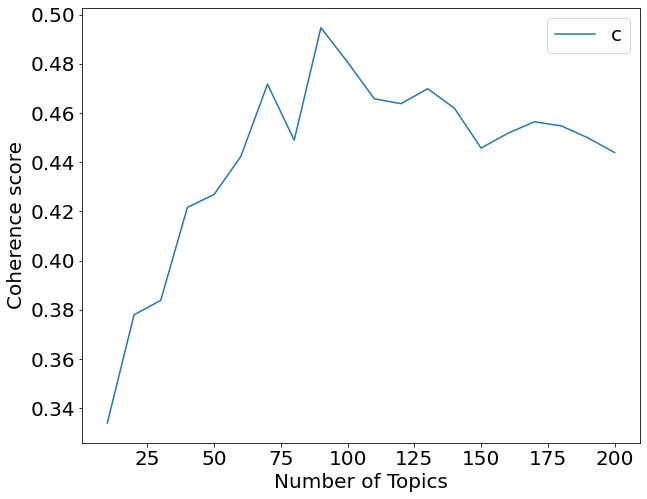

In [25]:
# Show graph
#this will change
fig = plt.gcf()

limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
fig.savefig('LDA_models_coherence.jpg')



In [26]:
# Print the coherence scores
coherence = zip(x, coherence_values)
sorted_coherence = sorted(coherence, key=lambda x: x[1], reverse=True)

print(sorted_coherence)

for m, cv in sorted_coherence:
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

[(90, 0.49466693333679534), (100, 0.4806486131263663), (70, 0.47169881149198717), (130, 0.4698510738749141), (110, 0.4657444431231199), (120, 0.4637898663215886), (140, 0.461942983830826), (170, 0.4564084969737782), (180, 0.45475668178870277), (160, 0.45174267720605055), (190, 0.4498739506745625), (80, 0.44894194659133396), (150, 0.4457215921990442), (200, 0.44389338712793097), (60, 0.44229740608497214), (50, 0.4268513967123873), (40, 0.42161858752511866), (30, 0.383778137812637), (20, 0.3779247884197847), (10, 0.3339214851692642)]
Num Topics = 90  has Coherence Value of 0.4947
Num Topics = 100  has Coherence Value of 0.4806
Num Topics = 70  has Coherence Value of 0.4717
Num Topics = 130  has Coherence Value of 0.4699
Num Topics = 110  has Coherence Value of 0.4657
Num Topics = 120  has Coherence Value of 0.4638
Num Topics = 140  has Coherence Value of 0.4619
Num Topics = 170  has Coherence Value of 0.4564
Num Topics = 180  has Coherence Value of 0.4548
Num Topics = 160  has Coherence 

In [27]:
#pretty print is used to show models in a claen way
import pprint
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=True)
topics= optimal_model.print_topics(num_words=20)
topics

[(0,
  '0.032*"going" + 0.019*"nothing" + 0.019*"year" + 0.019*"think" + 0.013*"actually" + 0.013*"question" + 0.013*"last" + 0.013*"away" + 0.013*"therapist" + 0.013*"alone" + 0.013*"like" + 0.007*"part" + 0.007*"family" + 0.007*"need" + 0.007*"experience" + 0.007*"outside" + 0.007*"vulnerable" + 0.007*"pain" + 0.007*"people" + 0.007*"state"'),
 (1,
  '0.026*"work" + 0.017*"could" + 0.017*"help" + 0.017*"federal" + 0.017*"background" + 0.017*"answer" + 0.017*"check" + 0.017*"best" + 0.009*"everyone" + 0.009*"anything" + 0.009*"year" + 0.009*"reason" + 0.009*"told" + 0.009*"shipping" + 0.009*"verified" + 0.009*"rejected" + 0.009*"valuable" + 0.009*"identity" + 0.009*"childhood" + 0.009*"asked"'),
 (2,
  '0.037*"gift" + 0.028*"someone" + 0.028*"could" + 0.019*"wanted" + 0.019*"answer" + 0.019*"christmas" + 0.019*"money" + 0.010*"never" + 0.010*"wish" + 0.010*"want" + 0.010*"child" + 0.010*"good" + 0.010*"must" + 0.010*"much" + 0.010*"head" + 0.010*"live" + 0.010*"supposed" + 0.010*"fund

In [28]:
optimal_model.num_topics

20

In [29]:
!pip install pyLDAvis==3.2.2

In [31]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.063174 -0.139624       1        1  14.584927
3     -0.019786 -0.114032       2        1  12.347007
5     -0.189427  0.017735       3        1  11.658642
11    -0.079463 -0.108613       4        1   9.217518
19    -0.053848 -0.032647       5        1   7.604724
9     -0.079970  0.122526       6        1   7.177123
8     -0.088098  0.130871       7        1   4.990942
7      0.104843 -0.014591       8        1   4.481846
0      0.015415 -0.048561       9        1   3.924971
6     -0.031428  0.022379      10        1   3.794135
15     0.063698 -0.008598      11        1   3.772514
18    -0.022432  0.065138      12        1   2.886134
4     -0.003944  0.043806      13        1   2.821943
1      0.112045  0.001896      14        1   2.586189
10    -0.003260 -0.023265      15        1   2.345021
17     0.071543  0.018006      16        1   2.301107
2      0.108232  0.057901      17        1   2.179350
13     0.046296  0.001472      18        1   0.587116
16     0.061049  0.005343      19        1   0.484138
14     0.051709  0.002856      20        1   0.254652, topic_info=        Term       Freq      Total Category  logprob  loglift
98      like  30.000000  30.000000  Default   30.000  30.0000
20     going  18.000000  18.000000  Default   29.000  29.0000
75      feel  15.000000  15.000000  Default   28.000  28.0000
80      love  11.000000  11.000000  Default   27.000  27.0000
56      life  15.000000  15.000000  Default   26.000  26.0000
..       ...        ...        ...      ...      ...      ...
22      lose   0.006086   4.616357  Topic20   -7.013  -0.6584
23      lost   0.006086   3.991265  Topic20   -7.013  -0.5129
24  medicine   0.006086   1.469440  Topic20   -7.013   0.4863
25    monday   0.006086   1.469440  Topic20   -7.013   0.4863
26     month   0.006086   4.100390  Topic20   -7.013  -0.5399

[1083 rows x 6 columns], token_table=      Topic      Freq                                    Term
term                                                         
742       1  0.670354                              *facepalm*
615       1  0.670354                               *usually*
1007      2  0.860523  //www.fosterclub.com/blog/real-stories
739       5  0.711848                             /r/fosterit
766      16  0.854136                               abandoned
...     ...       ...                                     ...
111      14  0.055067                                    year
554       5  0.733169                                   youth
554      17  0.366584                                   youth
789      16  0.854094                                    zero
681      10  0.784253                                   🤷🏻‍♀️

[1422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 6, 12, 20, 10, 9, 8, 1, 7, 16, 19, 5, 2, 11, 18, 3, 14, 17, 15])